In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf

import glob
import sys
import os
from collections import OrderedDict

import csv

sys.path.insert(0, "../casa/")
from plot_utils import *
from genome_utils import *

# General Setup
This is a small analysis of _MYC_ and _CD164_.

Collecting files here.

In [2]:
# Guide score files
M1R1_fn = '../data/MYC_R1_detailed_simplified.txt'
M1R2_fn = '../data/MYC_R2_detailed_simplified.txt'
PVR1_fn = '../data/PVT1_R1_detailed_simplified.txt'
PVR2_fn = '../data/PVT1_R2_detailed_simplified.txt'

fn_list = [M1R1_fn,M1R2_fn,
           PVR1_fn,PVR2_fn]

exp_ids = ['M1R1','M1R2','PVR1','PVR2']

fullinfo= [("MYC",1), ("MYC",2),
           ("PVT1",1),("PVT1",2)]

id2info = { exp_id: info for exp_id, info in zip(exp_ids, fullinfo) }

id2info['k27'] = ('H3K27ac', 1)
id2info['DHS'] = ('DHS', 1)
id2info['FUL'] = ('Fulco', 1)

In [3]:
# Peak BED files
# MAINTAIN ORDER (see exp_ids variable above)
#M1R1_bed= '../data/MYC_rep1__highresPeaks.bed'
#M1R2_bed= '../data/MYC_rep2__highresPeaks.bed'
M1R1_bed= '../data/MYC_rep1__highresLowthreshPeaks.bed'
M1R2_bed= '../data/MYC_rep2__highresLowthreshPeaks.bed'
#M1R1_bed= '../data/MYC_rep1__lowresLowthreshPeaks.bed'
#M1R2_bed= '../data/MYC_rep2__lowresLowthreshPeaks.bed'

PVR1_bed= '../data/PVT1_rep1__highresLowthreshPeaks.bed'
PVR2_bed= '../data/PVT1_rep1__highresLowthreshPeaks.bed'

exp_beds= [M1R1_bed, M1R2_bed, PVR1_bed, PVR2_bed]

K27_bed = '../data/k27ac_replicatePeaks_hg38_scoreFiltered.bed'
DHS_bed = '../data/DNASE_peaks_replicated.bed'

FUL_bed = '../data/DHS_fulco_intersect_merge_curated.bed'

extra_beds = [ K27_bed, DHS_bed, FUL_bed ]
extra_tags = [ 'k27', 'DHS', 'FUL' ]

In [4]:
# Target BEDs for post-processed peak calls
# Maintain relative assay target ordering
M1_targ = '../data/MYC__replicatingPeaks.bed'

BED_dump = [M1_targ]

# Load and preprocess data

In [5]:
gff = pd.read_table('../data/MYC_locus.gff')

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [6]:
gff

,name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,geneID
0,ENST00000644627.1,chr8,+,126865907,127064901,126865907,126865907,5,"126865907,126877671,126926317,127006554,127064047","126866353,126877790,126926399,127006618,127064901",PCAT1
1,ENST00000635449.1,chr8,+,127079873,127092600,127079873,127079873,1,127079873,127092600,PRNCR1
2,ENST00000502082.5,chr8,-,127289816,127482139,127289816,127289816,6,"127289816,127420828,127479082,127479703,127480...","127290060,127420963,127479170,127479806,127481...",CASC8
3,ENST00000645438.1,chr8,+,127322182,127417210,127415866,127416946,4,"127322182,127339280,127414887,127415442","127322226,127339435,127415022,127417210",POU5F1B
4,ENST00000630920.1,chr8,+,127400398,127402150,127400398,127400398,1,127400398,127402150,CCAT2
5,ENST00000502463.7,chr8,-,127686342,127733967,127686342,127686342,3,"127686342,127691789,127733824","127689423,127691866,127733967",CASC11
6,ENST00000613283.2,chr8,+,127736593,127740958,127736593,127740958,3,"127736593,127738247,127740395","127736623,127739019,127740958",MYC
7,ENST00000624314.1,chr8,-,127946558,127948723,127946558,127946558,1,127946558,127948723,TMEM75
8,ENST00000663059.1,chr8,+,127795798,128101256,127795798,127795798,6,"127795798,127890588,127939507,127989161,128096...","127796008,127890998,127939676,127989291,128096...",PVT1


In [7]:
data = []
for i, fn in enumerate(fn_list):
    print(fn)
    d_pt = pd.read_table(fn,sep='\t',header=0)
    ## Rescale to floats
    rescale = min(d_pt['LS_reads'].sum(),d_pt['HS_reads'].sum()) / d_pt.loc[:,('HS_reads','LS_reads')].sum(axis=0)
    d_pt.loc[:,('HS_reads','LS_reads')] *= rescale
    ## Sample downsized library
    runif              = np.random.uniform(size=d_pt.loc[:,('HS_reads','LS_reads')].shape)
    int_part, sample_p = np.divmod( d_pt.loc[:,('HS_reads','LS_reads')], 1 )
    d_pt.loc[:,('HS_reads','LS_reads')] = int_part + (runif < sample_p)
    ## Return as int
    d_pt.loc[:,('HS_reads','LS_reads')] = d_pt.loc[:,('HS_reads','LS_reads')].astype(int) + 1
    d_pt[exp_ids[i]] = np.log( d_pt['LS_reads'] / d_pt['HS_reads'] )
    data.append( d_pt.loc[((~d_pt['Coordinates'].str.contains("NT")) &\
                           (~d_pt['Coordinates'].str.contains("CTRL")) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-LV2')) &\
                           (~d_pt['Coordinates'].str.contains('FILLER-SgO'))),
                          ('Coordinates',exp_ids[i])] )

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead.
  after removing the cwd from sys.path.


../data/MYC_R1_detailed_simplified.txt
../data/MYC_R2_detailed_simplified.txt
../data/PVT1_R1_detailed_simplified.txt
../data/PVT1_R2_detailed_simplified.txt


In [8]:
data = pd.concat([ df.set_index('Coordinates') for df in data ],axis=1)

In [9]:
data['cutsite'] = [ int(coord.split(':')[1].split('-')[1]) - 4 
                      if coord.split(':')[-1] == '+' 
                      else 
                    int(coord.split(':')[1].split('-')[0]) + 3 
                      for coord in data.index ]

In [10]:
# Get experimental peaks
## Read in files
test_peaks = [ pd.read_table(
                 fn,sep='\t',header=None,
                 names=['chr','start','end','hdr','pass','strand']
               ) 
               for fn in exp_beds ]
## Figure out which chromosomes were tested
tested_chr = pd.concat( test_peaks, axis=0 )['chr'].unique()
## Filter out non-significant peaks
test_peaks = [ merge_bed(
                   df.loc[ df['pass'] == True, ('chr','start','end') ].copy()
               )
               for df in test_peaks ]
## Filter out tiny peaks
test_peaks = [ df[ (df['end'] - df['start']) > 100 ] if 'cut' not in fullinfo[i][0] 
               else df[ (df['end'] - df['start']) > 50 ]
               for i, df in enumerate(test_peaks) ]

print("Experimental track count: {}".format(len(test_peaks)))

# Add on extra features from ENCODE
## Read in files
extra_feat = [ pd.read_table(fn,sep='\t',header=None,
                             names=['chr','start','end'],usecols=[0,1,2]) 
               for fn in extra_beds ]
## Filter out un-tested chromosomes for speed
chr_filters = [ np.vstack([feat['chr'] == chrom for chrom in tested_chr ]).any(axis=0) 
                for feat in extra_feat ]

# Combine
[ test_peaks.append( feat.loc[ chr_filter ,:] ) for feat, chr_filter in zip(extra_feat, chr_filters) ]
test_peaks = [ df.reset_index(drop=True) for df in test_peaks ]
print("Total track count: {}".format(len(test_peaks)))
for exp_id, peaks_idx in zip(exp_ids+extra_tags,range(len(test_peaks))):
    test_peaks[peaks_idx]['exp_id'] = exp_id
    test_peaks[peaks_idx]['assay'] = id2info[exp_id][0]
    test_peaks[peaks_idx]['replicate'] = id2info[exp_id][1]
    
test_peaks = pd.concat(test_peaks,axis=0,ignore_index=True)


/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: read_table is deprecated, use read_csv instead.
  import sys
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: read_table is deprecated, use read_csv instead.


Experimental track count: 4
Total track count: 7


In [11]:
data['cutsite'].max()

128735227

# Plot guide-wise scores with peaks
Lines indicate min-max interval between all replicates.

MYC
71
PVT1
55


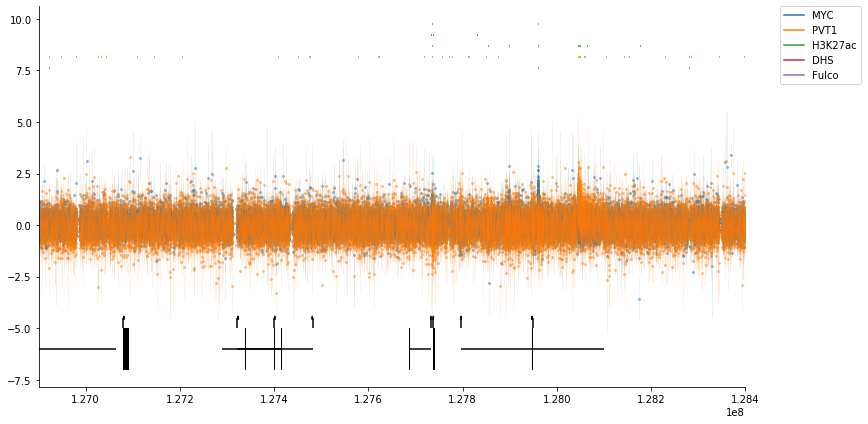

In [12]:
fig_h, ax_h = plot_combined_cutsites(np.array([[126900000,128400000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
4
PVT1
4


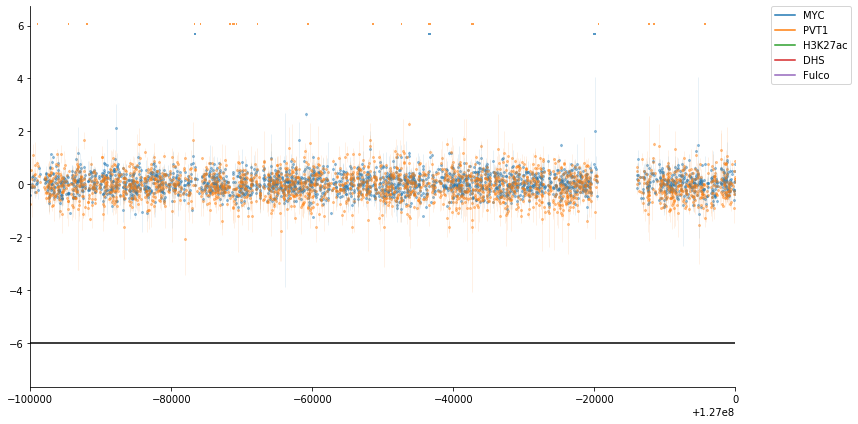

In [13]:
fig_h, ax_h = plot_combined_cutsites(np.array([[126900000,127000000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
6
PVT1
2


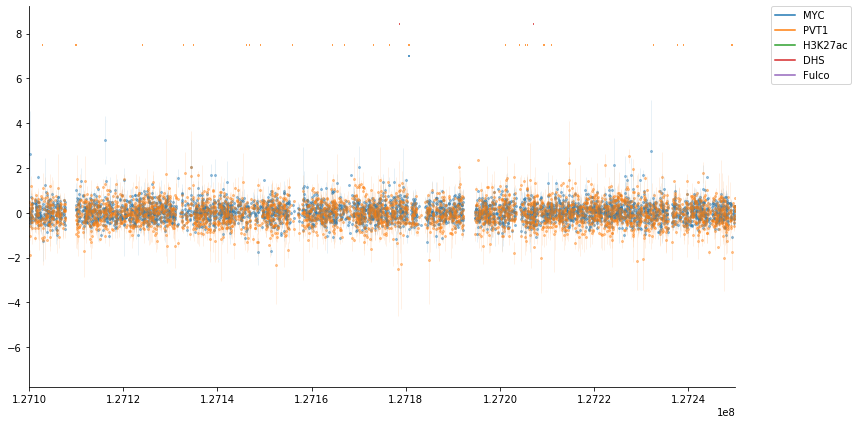

In [14]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127100000,127250000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
7
PVT1
7


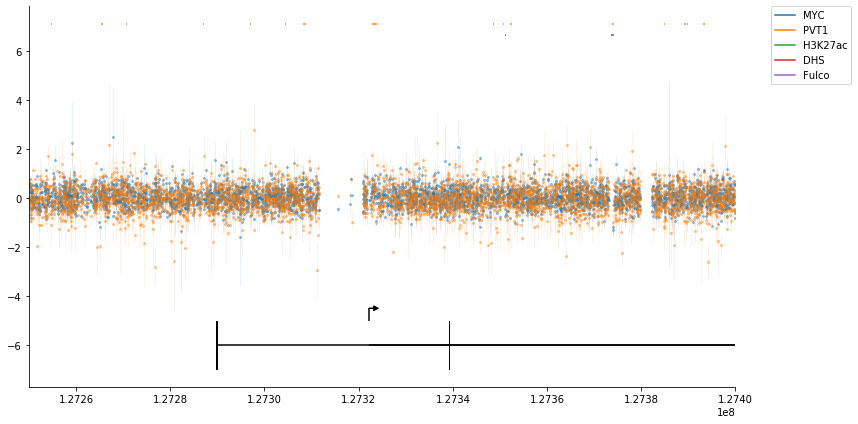

In [15]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127250000,127400000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
6
PVT1
5


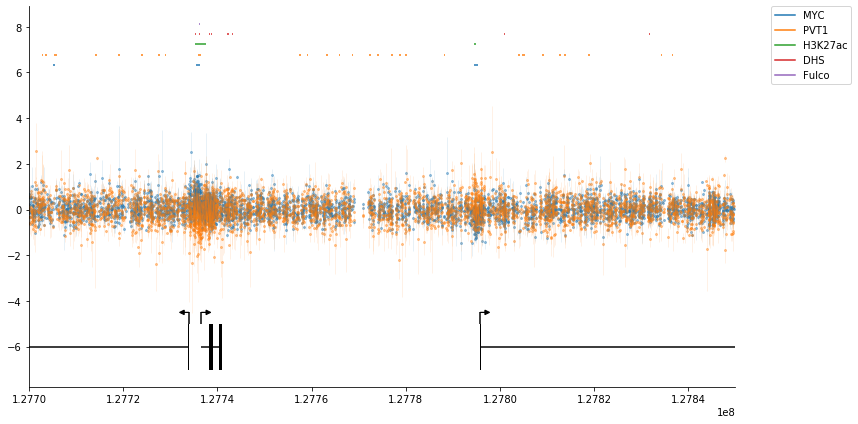

In [16]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127700000,127850000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
9
PVT1
11


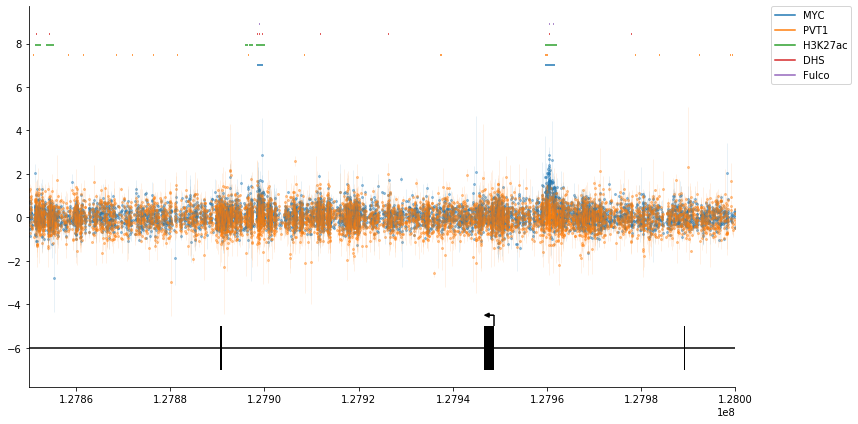

In [17]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127850000,128000000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
4
PVT1
6


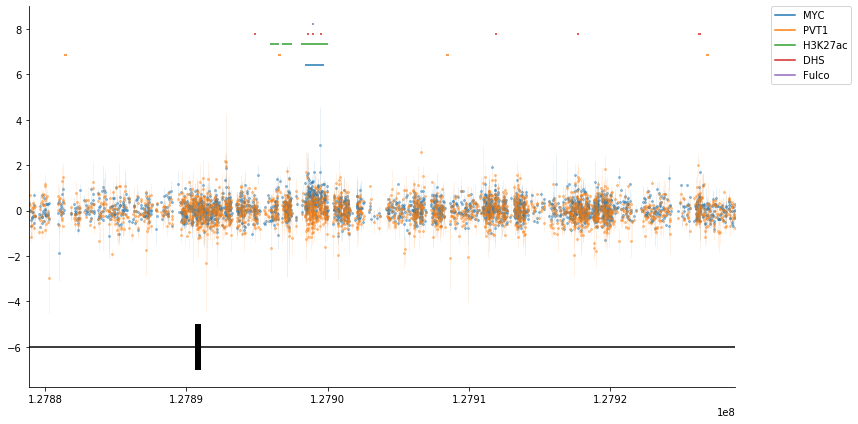

In [18]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127878855,127928855]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
14
PVT1
10


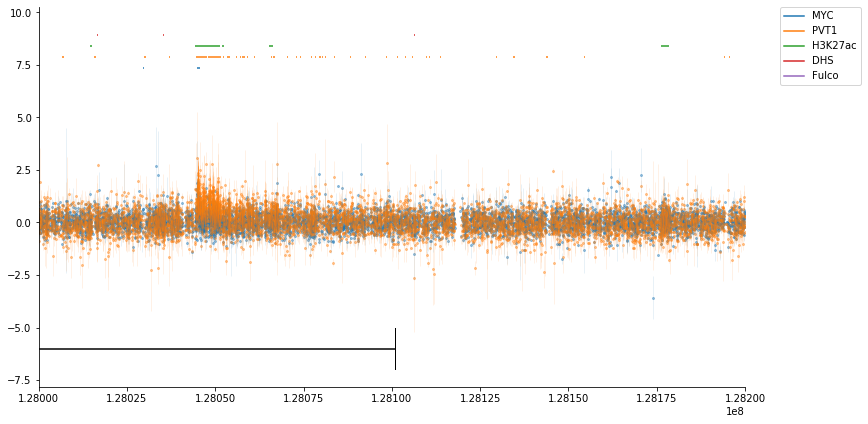

In [19]:
fig_h, ax_h = plot_combined_cutsites(np.array([[128000000,128200000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
6
PVT1
2


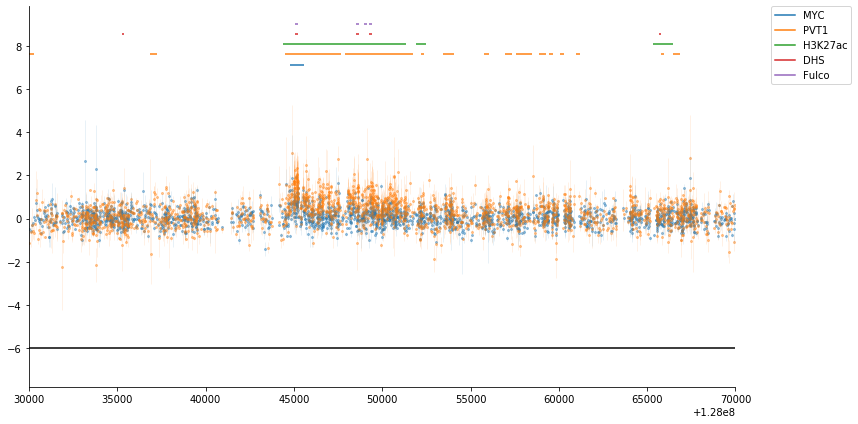

In [20]:
fig_h, ax_h = plot_combined_cutsites(np.array([[128030000,128070000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
7
PVT1
4


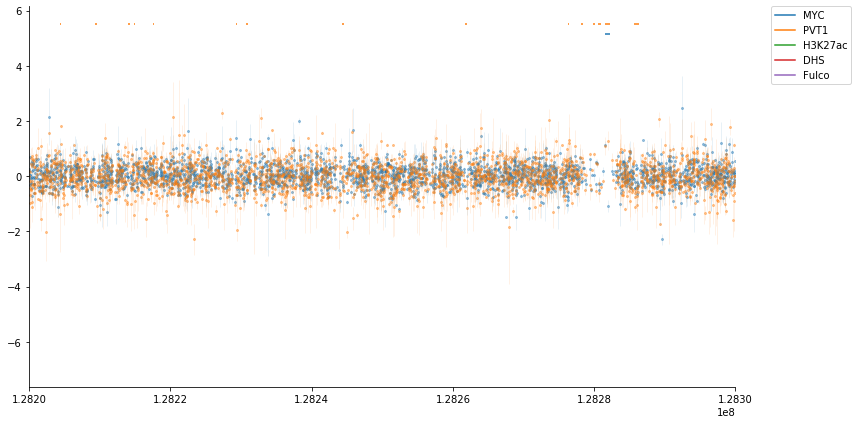

In [21]:
fig_h, ax_h = plot_combined_cutsites(np.array([[128200000,128300000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
5
PVT1
3


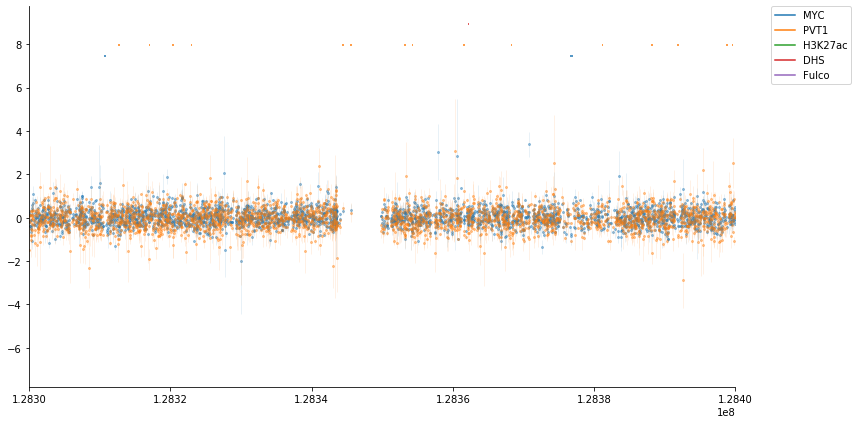

In [22]:
fig_h, ax_h = plot_combined_cutsites(np.array([[128300000,128400000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
6
PVT1
5


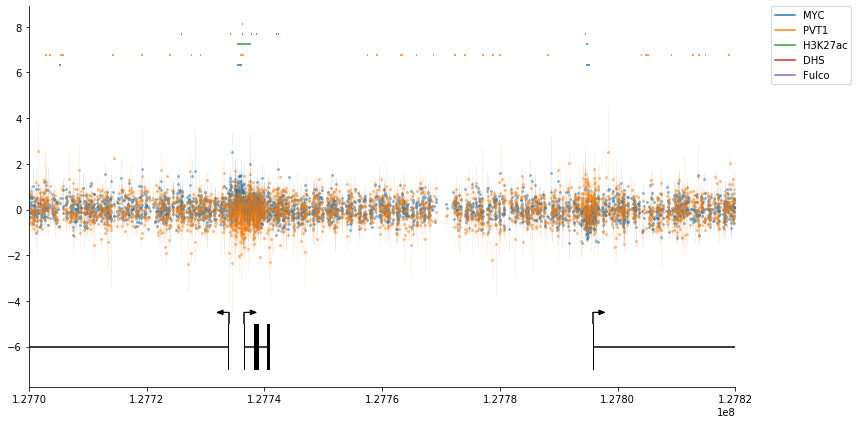

In [23]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127700000,127820000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
8
PVT1
10


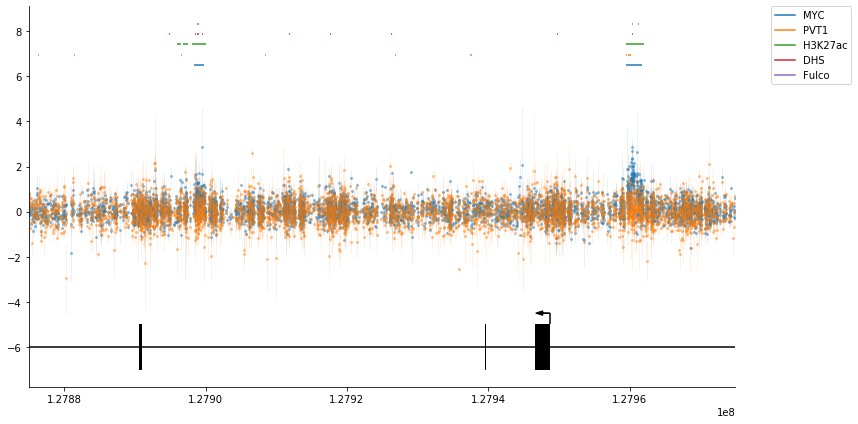

In [24]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127875000,127975000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
20
PVT1
20


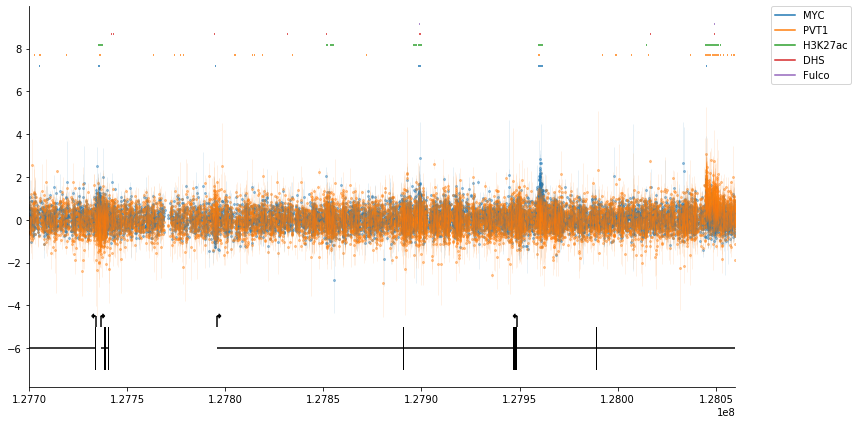

In [25]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127700000,128060000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
12
PVT1
7


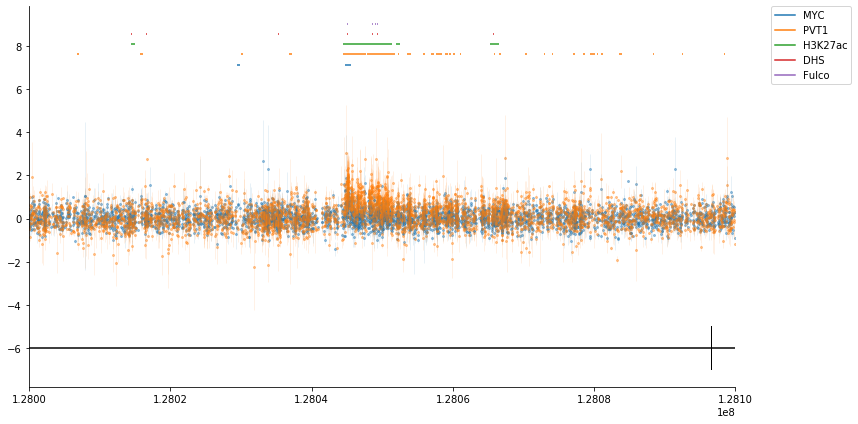

In [26]:
fig_h, ax_h = plot_combined_cutsites(np.array([[128000000,128100000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
3
PVT1
3


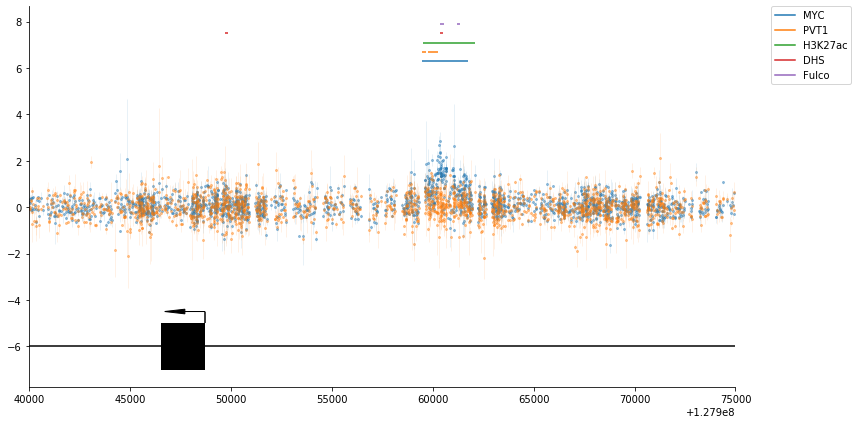

In [27]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127940000,127975000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS','FUL'])
draw_genes_from_gff(ax_h, gff)

MYC
3
PVT1
4


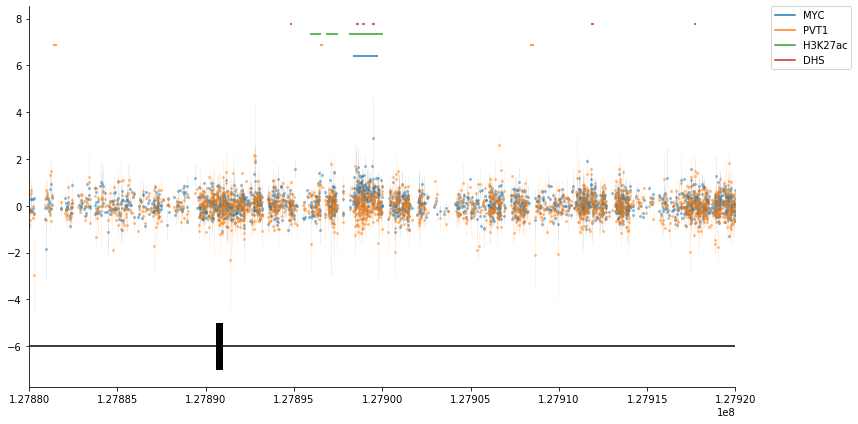

In [28]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127880000,127920000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff)

MYC
5
PVT1
3


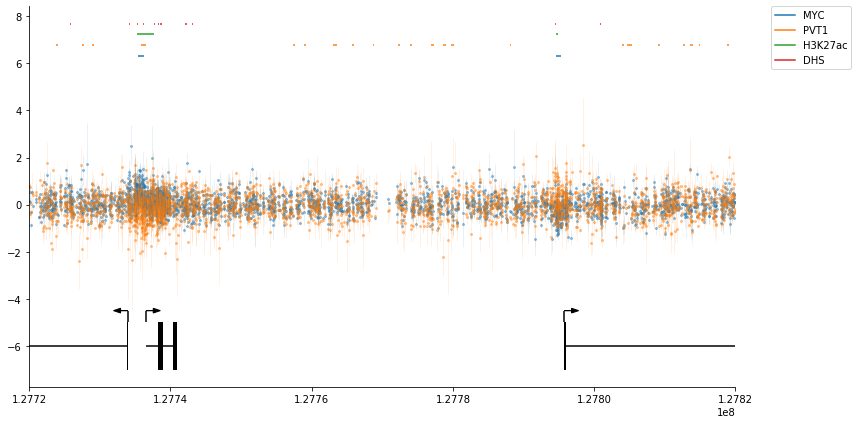

In [29]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127720000,127820000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff)

MYC
18
PVT1
20


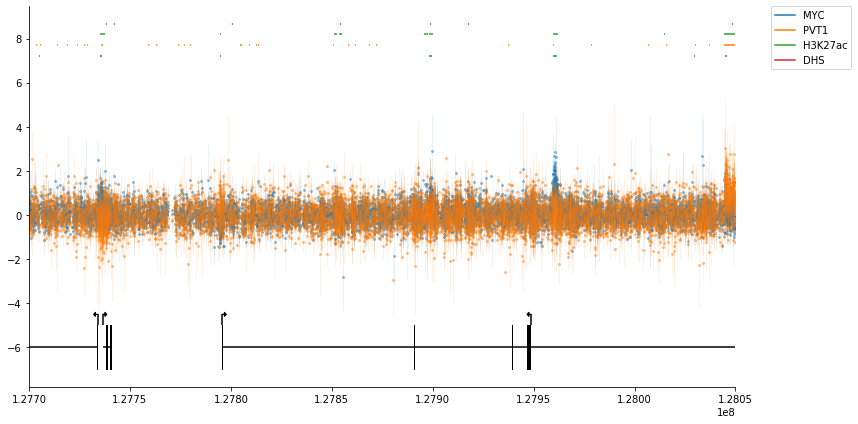

In [30]:
fig_h, ax_h = plot_combined_cutsites(np.array([[127700000,128050000]]), 
          data, test_peaks, plot_ids=['M1R1','M1R2','PVR1','PVR2','k27','DHS'])
draw_genes_from_gff(ax_h, gff)

## Break up guide-wise scores by individual reps

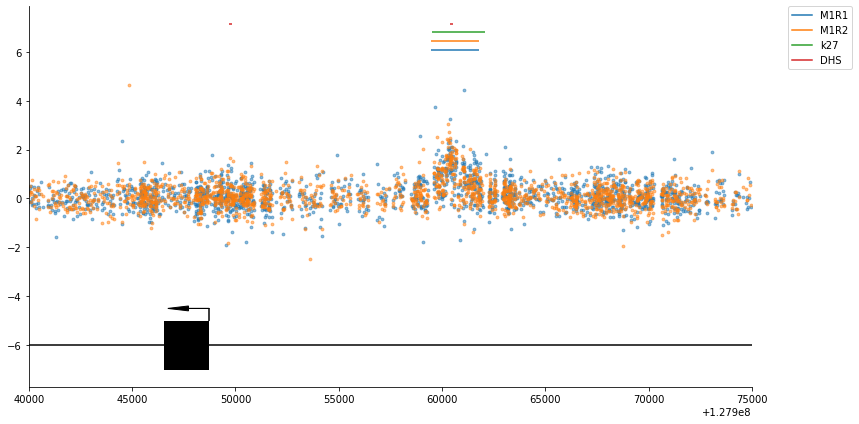

In [31]:
fig_h = plot_hff_cutsites(np.array([[127940000,127975000]]), 
                  data, test_peaks, plot_ids=['M1R1','M1R2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff)

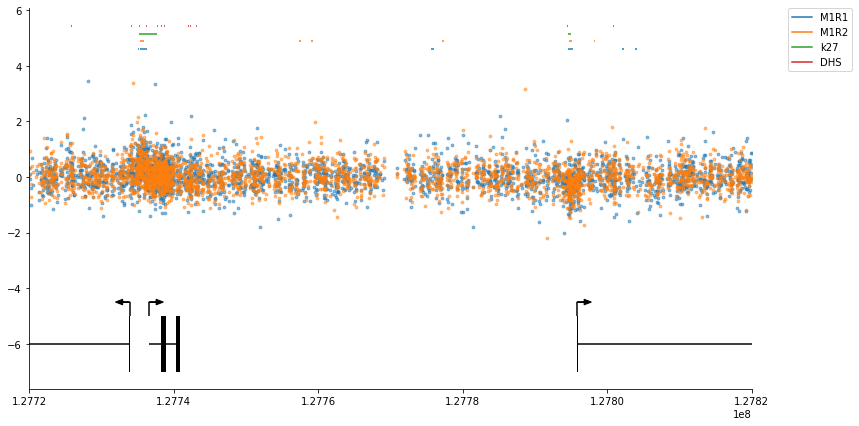

In [32]:
fig_h = plot_hff_cutsites(np.array([[127720000,127820000]]), 
                  data, test_peaks, plot_ids=['M1R1','M1R2','k27','DHS'])
draw_genes_from_gff(fig_h[1], gff)

# Connection diagram

In [33]:
txn_starts = extract_txn_starts(gff)

pack_TSSs   = [('MYC',txn_starts['MYC'][0],txn_starts['MYC'][1]),
               ('PVT1',txn_starts['PVT1'][0],txn_starts['MYC'][1])]

In [34]:
txn_starts

{'PCAT1': ('chr8', 126865907),
 'PRNCR1': ('chr8', 127079873),
 'CASC8': ('chr8', 127482139),
 'POU5F1B': ('chr8', 127322182),
 'CCAT2': ('chr8', 127400398),
 'CASC11': ('chr8', 127733967),
 'MYC': ('chr8', 127736593),
 'TMEM75': ('chr8', 127948723),
 'PVT1': ('chr8', 127795798)}

In [35]:
MYC_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'MYC')] ), 
    pd.read_table(M1R1_fn,sep='\t',header=0)['Coordinates'], min_coverage=29
)

PVT_only_peaks = filter_by_guide_coverage(
    get_replicating_peaks( test_peaks[(test_peaks['assay'] == 'PVT1')] ), 
    pd.read_table(M1R1_fn,sep='\t',header=0)['Coordinates'], min_coverage=29
)

pack_peaks       = [MYC_only_peaks, PVT_only_peaks]

all_locus_peaks = pd.concat(pack_peaks).reset_index(drop=True)

/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sagergosai/miniconda3/envs/casa/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: read_table is deprecated, use read_csv instead.
  


In [36]:
all_locus_peaks

,chr,start,end,guide_coverage
0,chr8,127735369,127736269,136
1,chr8,127794569,127795269,103
2,chr8,127898369,127899769,179
3,chr8,127959469,127961769,226
4,chr8,128044769,128045569,101
5,chr8,127735869,127736569,111
6,chr8,127959769,127960269,84
7,chr8,128044469,128047669,272
8,chr8,128047869,128051769,323
9,chr8,128052169,128052369,40


In [37]:
# MYC
MYC_total_scores = get_peak_strengths(M1R1_bed, M1R2_bed)
PVT_total_scores = get_peak_strengths(PVR1_bed, PVR2_bed)

pack_scores = [MYC_total_scores, PVT_total_scores]


../casa/plot_utils.py:312: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  for fn in argv ]


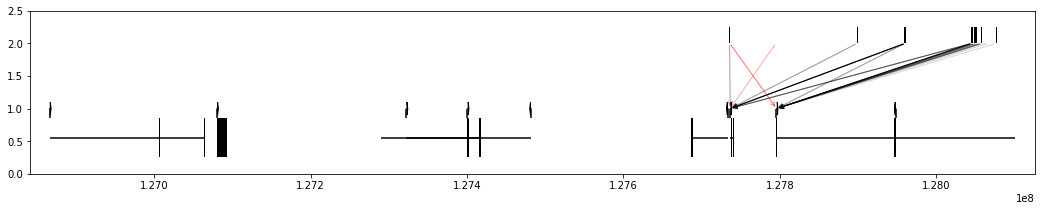

In [38]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
ax.set_xlim( gff_to_locus_lims(gff,0.02) )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[1000,0.2,1000], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MYC'], y_anchor=2.0, y_target=1.0, score_bed=MYC_total_scores)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['PVT1'], y_anchor=2.0, y_target=1.0, score_bed=PVT_total_scores)

plt.savefig('plots/MYC_locus__full_locus__connectogram.pdf')

plt.show()

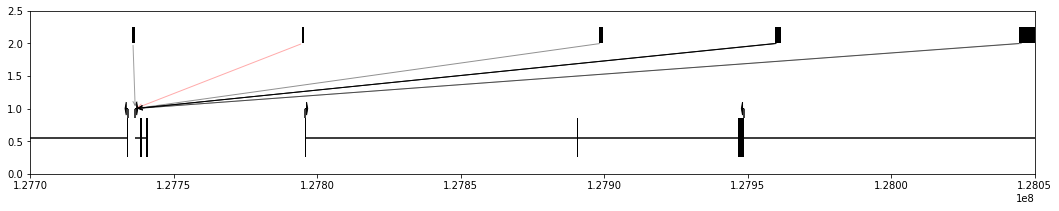

In [39]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [127700000,128050000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MYC'], y_anchor=2.0, y_target=1.0, score_bed=MYC_total_scores, xlims=glims)

plt.savefig('plots/MYC_locus__127686432_128091535__connectogram.pdf')

plt.show()

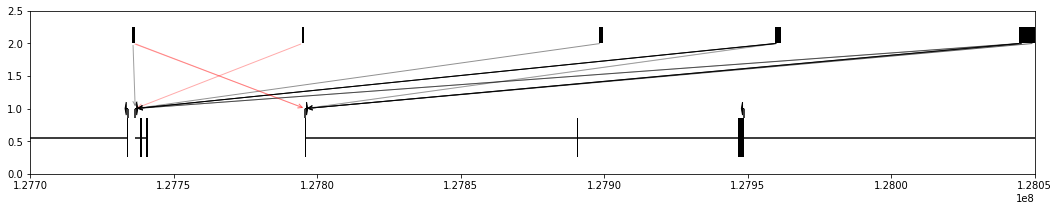

In [40]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [127700000,128050000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MYC'], y_anchor=2.0, y_target=1.0, score_bed=MYC_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['PVT1'], y_anchor=2.0, y_target=1.0, score_bed=PVT_total_scores, xlims=glims)

plt.savefig('plots/MYC_locus__127686432_128091535__connectogram.pdf')

plt.show()

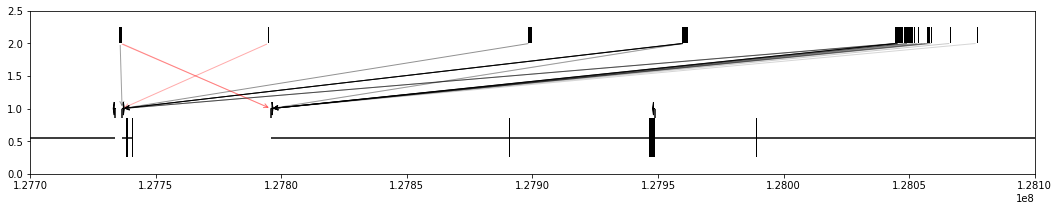

In [41]:
fig = plt.figure(figsize=(18,3))
ax  = plt.subplot(111)
glims = [127700000,128100000]
ax.set_xlim( *glims )
ax.set_ylim(0.0, 2.5)
draw_genes_from_gff(ax, gff, promoter_params=[500,0.2,400], gene_ylim=[0.25,1.0])
draw_bed_blocks(ax, all_locus_peaks, ylims=[2.0,2.25])
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['MYC'], y_anchor=2.0, y_target=1.0, score_bed=MYC_total_scores, xlims=glims)
connect_bed_to_genes(ax, all_locus_peaks, txn_starts['PVT1'], y_anchor=2.0, y_target=1.0, score_bed=PVT_total_scores, xlims=glims)

plt.savefig('plots/MYC_locus__127686432_128091535__connectogram.pdf')

plt.show()

# Export replicating peaks

In [46]:
write_bed_format([ x.iloc[:,0:3] for x in pack_peaks ], pack_scores, pack_TSSs, 
                 '../data/MYC_locus__replicatingPeaks.bed')
